<a href="https://colab.research.google.com/github/Euan-Kearney/cancer-cam/blob/main/model_0_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
# Uninstalls existing kaggle files to resolve potential API issues
!pip uninstall -y kaggle kagglesdk

Found existing installation: kaggle 2.0.0
Uninstalling kaggle-2.0.0:
  Successfully uninstalled kaggle-2.0.0
Found existing installation: kagglesdk 0.1.15
Uninstalling kagglesdk-0.1.15:
  Successfully uninstalled kagglesdk-0.1.15


In [22]:
%%shell
pip install -q kagglesdk
pip install -q kaggle
pip install -q opendatasets

In [4]:
from google.colab import userdata
import json
import os

# Retrieve kaggle key and import json
kaggle_json_str = userdata.get('KAGGLE_JSON')
kaggle_dict = json.loads(kaggle_json_str)
os.makedirs('/root/.kaggle', exist_ok=True)
with open('/root/.kaggle/kaggle.json', 'w') as f:
    json.dump(kaggle_dict, f)

!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000 -p /content/HAM10000 --unzip --quiet

Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0


In [5]:
from sklearn.model_selection import train_test_split
from pathlib import Path
import pandas as pd
import shutil

base = 'HAM10000_organised'
splits = ['train', 'validate', 'test']
os.makedirs(base, exist_ok=True)

classes = [
    'melanoma',
    'BCC',
    'SCC',
    'low_risk'
]

# Setup organised directories to allow for the creation of dataframes
for split in splits:
    for cls in classes:
        path = os.path.join(base, split, cls)
        os.makedirs(path, exist_ok=True)

os.makedirs(base, exist_ok=True)

"""
Maps HAM10000 classes to the 4 cancer-cam classes
"""
def map_classes(cls):
  if cls == 'mel':
    return 'melanoma'
  elif cls == 'bcc':
    return 'BCC'
  elif cls == 'akiec':
    return 'SCC'
  elif cls == 'bkl':
    return 'low_risk'
  elif cls == 'df':
    return 'low_risk'
  elif cls == 'nv':
    return 'low_risk'
  elif cls == 'vasc':
    return 'low_risk'
"""
Copies images from HAM10000 folder to the HAM10000_organised folder
"""
def copy_images(split, dataframe):
  for index, row in dataframe.iterrows():
    image_name = row['image_id'] + '.jpg'
    cls = map_classes(row['dx'])
    part_1_source = os.path.join('HAM10000/HAM10000_images_part_1/', image_name)
    part_2_source = os.path.join('HAM10000/HAM10000_images_part_2/', image_name)
    destination = os.path.join('HAM10000_organised/', split, cls, image_name)
    # Checks if image already exists in new dir, ceasing the for loop if so
    if os.path.exists(destination):
      break
    # Checks if the image exists in the part_1 HAM10000 dir, or the part_2 folder
    if os.path.exists(part_1_source):
      shutil.copyfile(part_1_source, destination)
    elif os.path.exists(part_2_source):
      shutil.copyfile(part_2_source, destination)

all_data = pd.read_csv('HAM10000/HAM10000_metadata.csv')
train_df, temp_df = train_test_split(all_data, test_size=0.2, random_state=22)
validate_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=22)

for split in splits:
  if split == 'train':
    copy_images(split, train_df)
  elif split == 'validate':
    copy_images(split, validate_df)
  else:
    copy_images(split, test_df)




In [6]:
# Verifies number of images in each dir
def count_images(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
count_images('HAM10000_organised/')

There are 3 directories and 0 images in 'HAM10000_organised/'.
There are 4 directories and 0 images in 'HAM10000_organised/train'.
There are 0 directories and 262 images in 'HAM10000_organised/train/SCC'.
There are 0 directories and 6449 images in 'HAM10000_organised/train/low_risk'.
There are 0 directories and 409 images in 'HAM10000_organised/train/BCC'.
There are 0 directories and 892 images in 'HAM10000_organised/train/melanoma'.
There are 4 directories and 0 images in 'HAM10000_organised/validate'.
There are 0 directories and 35 images in 'HAM10000_organised/validate/SCC'.
There are 0 directories and 807 images in 'HAM10000_organised/validate/low_risk'.
There are 0 directories and 57 images in 'HAM10000_organised/validate/BCC'.
There are 0 directories and 102 images in 'HAM10000_organised/validate/melanoma'.
There are 4 directories and 0 images in 'HAM10000_organised/test'.
There are 0 directories and 30 images in 'HAM10000_organised/test/SCC'.
There are 0 directories and 805 imag

In [27]:
import torch
import torchvision

from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Removes non image files from image directories
!rm -R HAM10000_organised/train/.ipynb_checkpoints
!rm -R HAM10000_organised/validate/.ipynb_checkpoints
!rm -R HAM10000_organised/test/.ipynb_checkpoints

# Lighweight B0 model has its weight's and image transformations retrieved
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
auto_transforms = weights.transforms()

train_data = datasets.ImageFolder("HAM10000_organised/train", transform=auto_transforms)
validate_data = datasets.ImageFolder("HAM10000_organised/validate", transform=auto_transforms)
test_data = datasets.ImageFolder("HAM10000_organised/test", transform=auto_transforms)

train_dataloader = DataLoader(
    train_data,
    batch_size=64,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

validate_dataloader = DataLoader(
    validate_data,
    batch_size=64,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

test_dataloader = DataLoader(
    test_data,
    batch_size=62,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print(validate_dataloader.dataset.class_to_idx)



rm: cannot remove 'HAM10000_organised/train/.ipynb_checkpoints': No such file or directory
rm: cannot remove 'HAM10000_organised/validate/.ipynb_checkpoints': No such file or directory
rm: cannot remove 'HAM10000_organised/test/.ipynb_checkpoints': No such file or directory
{'BCC': 0, 'SCC': 1, 'low_risk': 2, 'melanoma': 3}


In [28]:
# Uses GPU for training if available, otherwise uses CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

In [32]:
from torchsummary import summary

# Freeze existing layers to ensure they remain unaffected by further training
for param in model.features.parameters():
    param.requires_grad = False

torch.manual_seed(22)
torch.cuda.manual_seed(22)

model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=4,
                    bias=True)).to(device)

class_weights = torch.tensor([4.897, 7.645, 0.3106, 2.246], dtype=torch.float)
class_weights = class_weights.to(device)
loss_fn = nn.CrossEntropyLoss(weight=class_weights)
optimiser = torch.optim.Adam(model.parameters(), lr=0.0001)

In [38]:
from tqdm.auto import tqdm
from sklearn.metrics import f1_score

train_losses, train_accs, val_losses, val_accs, val_f1s = [], [], [], [], []

def train_epoch():
  model.train()

  running_loss = 0.0
  correct = 0
  total = 0

  for inputs, labels in train_dataloader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    optimiser.zero_grad()
    outputs = model(inputs)
    loss = loss_fn(outputs, labels)
    loss.backward()
    optimiser.step()

    running_loss = loss.item() * inputs.size(0)
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()

  epoch_loss = running_loss / total
  epoch_acc = 100. * correct / total

  train_losses.append(epoch_loss)
  train_accs.append(epoch_acc)

  return epoch_loss, epoch_acc

def validate_epoch():
    model.eval()

    running_loss = 0.0
    correct = 0
    total = 0

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for inputs, labels in validate_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_preds.append(predicted.detach().cpu())
            all_targets.append(labels.detach().cpu())

    val_loss = running_loss / total
    val_acc = 100. * correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)
    macro_f1 = f1_score(all_targets, all_preds, average='macro')
    val_f1s.append(macro_f1)

    return val_loss, val_acc, macro_f1

torch.manual_seed(42)
torch.cuda.manual_seed(42)

model.to(device)

for epoch in tqdm(range(30)):
  train_loss, train_acc = train_epoch()
  val_loss, val_acc, val_f1 = validate_epoch()
  print(f"epoch: {epoch} training loss: {train_loss} train accuracy: {train_acc} validate loss: {val_loss} validate accuracy: {val_acc} validate f1: {val_f1}")



  0%|          | 0/30 [00:00<?, ?it/s]

epoch: 0 training loss: 0.0014451686822945513 train accuracy: 63.56714927608587 validate loss: 0.9342676427338149 validate accuracy: 63.73626373626374 validate f1: 0.5120051415219438
epoch: 1 training loss: 0.0014072300431969996 train accuracy: 62.36894658012981 validate loss: 0.9033038882347015 validate accuracy: 63.93606393606394 validate f1: 0.5164627818354344
epoch: 2 training loss: 0.001000739369937556 train accuracy: 63.66699950074888 validate loss: 0.9123961465222972 validate accuracy: 63.336663336663335 validate f1: 0.5125774822672697
epoch: 3 training loss: 0.0015247518636557797 train accuracy: 63.54218671992012 validate loss: 0.8595739611974368 validate accuracy: 66.23376623376623 validate f1: 0.5273636710244071
epoch: 4 training loss: 0.0011033216120300445 train accuracy: 63.94158761857214 validate loss: 0.8153671256073943 validate accuracy: 66.63336663336663 validate f1: 0.5342902146116847
epoch: 5 training loss: 0.0010030525241324262 train accuracy: 65.35197204193709 valid

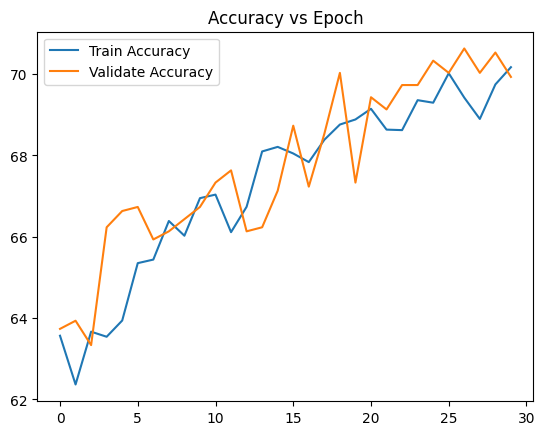

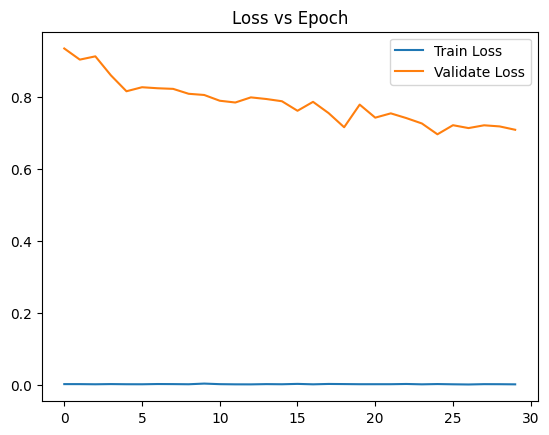

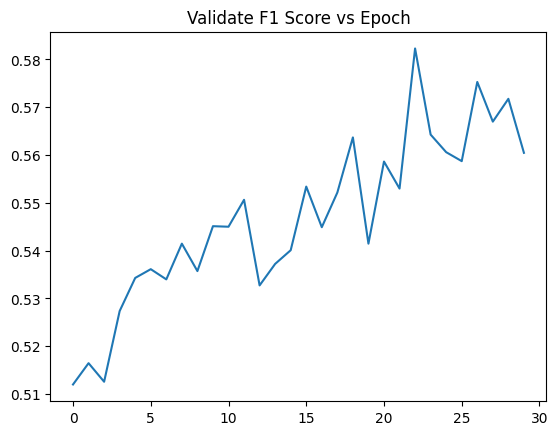

In [40]:
import matplotlib.pyplot as plt

plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validate Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()
plt.show()

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validate Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()

plt.plot(val_f1s, label='Validate F1 Score')
plt.title('Validate F1 Score vs Epoch')
plt.show()




In [42]:
from google.colab import drive
drive.mount('/content/drive')
destination_dir  = '/content/drive/MyDrive/cancer_cam/models'
model_path = os.path.join(destination_dir, 'model_0_c.pth')
torch.save(model, model_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
